In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats # For gaussian pdf
import cv2 as cv # For map generation

import collections
import math
import random

np.seterr('raise');
EPSILON = 1e-7

In [34]:
def prob_normal_distribution(a, b):
    return scipy.stats.norm(0, math.sqrt(b)).pdf(a)

def prob_triangular_distribution(a, b):
    return max(0, 1 / math.sqrt(6 * b) - abs(a) / 6 / b)

def sample_normal_distribution(b):
    return random.gauss(0, math.sqrt(b))

def sample_triangular_distribution(b):
    b = math.sqrt(b)
    return math.sqrt(6) / 2 * (random.uniform(-b, b) + random.uniform(-b, b))

# Taken from Kalman Filter book
def normalize_angle(x):
    x = x % (2 * math.pi)
    if x > math.pi:
        x -= 2 * math.pi
        
    return x

def motion_model_velocity(x_t, u_t, x_, dt, prob, alphas):
    x, y, theta = x_
    x_, y_, theta_ = x_t
    v, w = u_t
    
    mu = 0.5 * ((x - x_) * math.cos(theta) + (y - y_) * math.sin(theta)) / ((y - y_) * math.cos(theta) - (x - x_) * math.sin(theta) + EPSILON)
    x_star = (x + x_) / 2 + mu * (y - y_)
    y_star = (y + y_) / 2 + mu * (x - x_)
    r_star = math.sqrt((x - x_star)**2 + (y - y_star)**2)
    delta_theta = math.atan2(y_ - y_star, x_ - x_star) - math.atan2(y - y_star, x - x_star)
    v_ = delta_theta / dt * r_star
    w_ = delta_theta / dt
    gamma = normalize_angle((theta_ - theta) / dt - w_)
    
    p_1 = prob(v - v_, alphas[0] * v**2 + alphas[1] * w**2)
    p_2 = prob(w - w_, alphas[2] * v**2 + alphas[3] * w**2)
    p_3 = prob(gamma, alphas[4] * v**2 + alphas[5] * w**2)
    
    return p_1 * p_2 * p_3

def sample_motion_model_velocity(u_t, x_, dt, sample, alphas):
    x, y, theta = x_
    v, w = u_t
    
    v_ = v + sample(alphas[0] * v**2 + alphas[1] * w**2)
    w_ = w + sample(alphas[2] * v**2 + alphas[3] * w**2)
    gamma = sample(alphas[4] * v**2 + alphas[5] * w**2)
    x_ = x - v_ / w_ * math.sin(theta) + v_ / w_ * math.sin(theta + w_ * dt)
    y_ = y + v_ / w_ * math.cos(theta) - v_ / w_ * math.cos(theta + w_ * dt)
    theta_ = normalize_angle(theta + w_ * dt + gamma * dt)
    
    return np.array([x_, y_, theta_])

def sample_motion_model_velocity_n(u_t, positions, dt, sample, alphas):
    x_s = []
    y_s = []
    theta_s = []
    for x_t in zip(*positions):
        x, y, theta = sample_motion_model_velocity(u_t, x_t, dt, sample, alphas)
        x_s.append(x)
        y_s.append(y)
        theta_s.append(theta)
        
    return np.array(x_s), np.array(y_s), np.array(theta_s)

def motion_model_velocity_n(positions, u_t, prev_position, dt, prob, alphas):
    p_s = []
    for i in range(len(positions[0])):
        position = positions[0][i], positions[1][i], positions[2][i]
        p_s.append(motion_model_velocity(position, u_t, prev_position, dt, prob, alphas))
        
    return np.array(p_s)

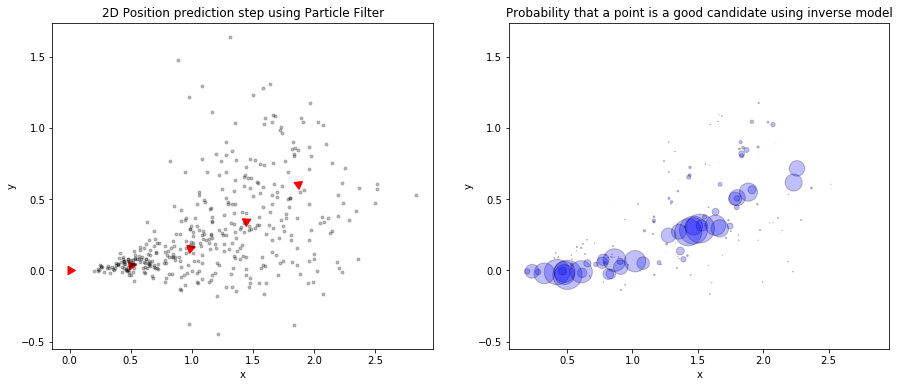

In [35]:
def simulate_predict_motion_model():
    DT = 0.5
    N_POINTS = 100
    N_EPOCH = 4

    u = np.array([1, math.pi / 10])
    sample = sample_normal_distribution
    prob = prob_normal_distribution
    alphas = [0.1] * 6
    no_noise_alphas = [0] * 6

    x_s = np.zeros(N_POINTS)
    y_s = np.zeros(N_POINTS)
    theta_s = np.zeros(N_POINTS)

    perfect_model = np.zeros(3)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
    axes[0].plot(x_s, y_s, 'k,', alpha=1)
    for _ in range(N_EPOCH):
        x_s, y_s, theta_s = sample_motion_model_velocity_n(u, (x_s, y_s, theta_s), DT, sample, alphas)
        p_s = motion_model_velocity_n((x_s, y_s, theta_s), u, perfect_model, DT, prob, alphas)
        perfect_model = sample_motion_model_velocity(u, perfect_model, DT, sample, no_noise_alphas)
        axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
        axes[0].plot(x_s, y_s, 'k.', alpha=0.25)
        
        axes[1].scatter(x_s, y_s, s=p_s * 500, alpha=0.25, c = 'b', edgecolors='k')

    axes[0].set_title('2D Position prediction step using Particle Filter')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    axes[1].set_title('Probability that a point is a good candidate using inverse model')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
simulate_predict_motion_model()

In [17]:
def motion_model_odometry(x_t, u_t, x_, prob, alphas):
    x, y, theta = x_
    x_, y_, theta_ = x_t
    delta_rot1, delta_trans, delta_rot2 = u_t
    
    delta_rot1_ = math.atan2(y_ - y, x_ - x) - theta
    delta_trans_ = math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2)
    delta_rot2_ = theta_ - theta - delta_rot1_
    
    p1 = prob(delta_rot1 - delta_rot1_, alphas[0] * delta_rot1_**2 + alphas[1] * delta_trans_**2)
    p2 = prob(delta_trans - delta_trans_, alphas[2] * delta_trans_**2 + alphas[3] * (delta_rot1_**2 + delta_rot2_**2))
    p3 = prob(delta_rot2 - delta_rot2_, alphas[0] * delta_rot2_**2 + alphas[1] * delta_trans_**2)
    
    return p1 * p2 * p3

def sample_motion_model_odometry(u_t, x_, sample, alphas):
    x, y, theta = x_
    delta_rot1, delta_trans, delta_rot2 = u_t
    
    delta_rot1_ = delta_rot1 - sample(alphas[0] * delta_rot1 ** 2 + alphas[1] * delta_trans ** 2)
    delta_trans_ = delta_trans - sample(alphas[2] * delta_trans ** 2 + alphas[3] * (delta_rot1 ** 2 + delta_rot2 ** 2))
    delta_rot2_ = delta_rot2 - sample(alphas[0] * delta_rot2 ** 2 + alphas[1] * delta_trans ** 2)
    
    x_ = x + delta_trans_ * math.cos(theta + delta_rot1)
    y_ = y + delta_trans_ * math.sin(theta + delta_rot2)
    theta_ = theta + delta_rot1_ + delta_rot2_
    
    return x_, y_, theta_

def sample_motion_model_odometry_n(u_t, positions, sample, alphas):
    x_s = []
    y_s = []
    theta_s = []
    for position in zip(*positions):
        x, y, theta = sample_motion_model_odometry(u_t, position, sample, alphas)
        x_s.append(x)
        y_s.append(y)
        theta_s.append(theta)
        
    return np.array(x_s), np.array(y_s), np.array(theta_s)

def motion_model_odometry_n(positions, u_t, prev_position, prob, alphas):
    p_s = []
    for i in range(len(positions[0])):
        position = positions[0][i], positions[1][i], positions[2][i]
        p_s.append(motion_model_odometry(position, u_t, prev_position, prob, alphas))
        
    return p_s

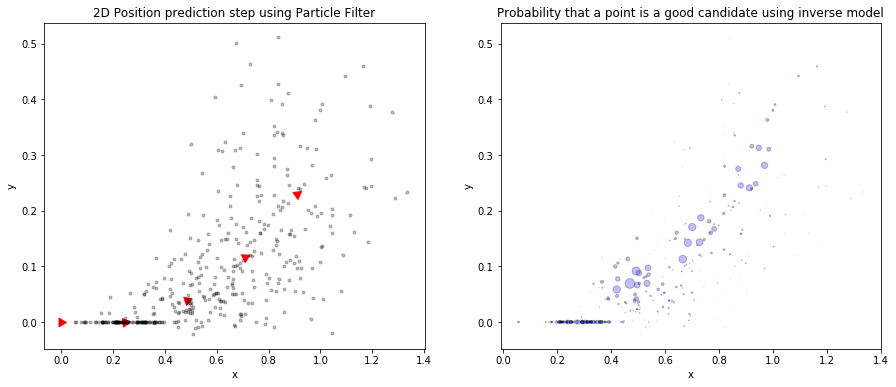

In [36]:
def simulate_predict_odometry_model():
    N_POINTS = 100
    N_EPOCH = 4

    u = np.array([math.pi / 20, 0.25, 0])
    sample = sample_normal_distribution
    prob = prob_normal_distribution
    alphas = [0.1] * 4
    no_noise_alphas = [0] * 4

    x_s = np.zeros(N_POINTS)
    y_s = np.zeros(N_POINTS)
    theta_s = np.zeros(N_POINTS)

    perfect_model = np.zeros(3)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
    axes[0].plot(x_s, y_s, 'k,', alpha=1)
    for _ in range(N_EPOCH):
        x_s, y_s, theta_s = sample_motion_model_odometry_n(u, (x_s, y_s, theta_s), sample, alphas)
        p_s = motion_model_odometry_n((x_s, y_s, theta_s), u, perfect_model, prob, alphas)
        perfect_model = sample_motion_model_odometry(u, perfect_model, sample, no_noise_alphas)
        axes[0].plot(perfect_model[0], perfect_model[1], 'r.', marker=(3, 0, math.degrees(perfect_model[2]) - 90), markersize=10)
        axes[0].plot(x_s, y_s, 'k.', alpha=0.25)
        
        axes[1].scatter(x_s, y_s, s=p_s * 100, alpha=0.25, c = 'b', edgecolors='k')

    axes[0].set_title('2D Position prediction step using Particle Filter')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    
    axes[1].set_title('Probability that a point is a good candidate using inverse model')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    
simulate_predict_odometry_model()

0.7978845608028654


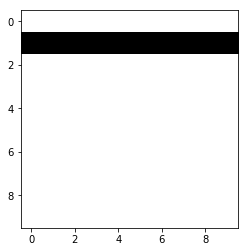

In [116]:
def prob_normal_distribution_clamped(x, stddev):
    if abs(x) > 4 * stddev:
        return 0
    
    return prob_normal_distribution(x, stddev ** 2)

def measurement_model_beam(x_t, m, z, z_max, stddev, d=0.25):
    x, y, theta = x_t
    dx = math.cos(theta)
    dy = math.sin(theta)
    p = 1
    most_probable = prob_normal_distribution(1.5 * stddev, stddev ** 2)
    x_, y_ = x, y
    i, j = int(round(y_)), int(round(x_))
    i_, j_ = i, j
    dist = 0

    while True:
        if i < 0 or y < 0 or i >= m.shape[0] or j >= m.shape[1]:
            break
        if dist >= z_max:
            q = p * prob_normal_distribution_clamped(z - z_max, stddev)
            most_probable = max(most_probable, q)
            break
        if (i_, j_) != (i, j):
            q = p * m[i, j] * prob_normal_distribution_clamped(z - dist, stddev)
            most_probable = max(most_probable, q)
            p *= 1 - q
            i_, j_ = i, j
            
        x_, y_ = x_ + dx *d, y_ + dy * d
        dist = math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2)
        i, j = int(round(y_)), int(round(x_))
        
    return most_probable

def simulate_probabilistic_raycast():
    m = np.array([
        [0.0] * 10
    ] * 10)
    m[1,] = 1
    x_t = np.array([5, 5, math.radians(180)])
    Z_MAX = 2
    STDDEV = 0.5
    z = 2

    print(measurement_model_beam(x_t, m, z, Z_MAX, STDDEV))
    plt.figure()
    plt.imshow(1 - m, cmap='gray')
    
simulate_probabilistic_raycast()

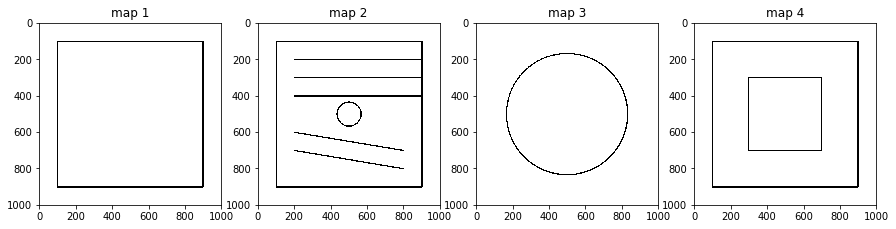

In [153]:
maps = []
MAP_SIZE = 1000
m = cv.rectangle(
    np.zeros((MAP_SIZE, MAP_SIZE)),
    (int(0.1 * MAP_SIZE), int(0.1 * MAP_SIZE)),
    (int(0.9 * MAP_SIZE), int(0.9 * MAP_SIZE)),
    1,
    5,
)
maps.append(m)


m = cv.line(
    m.copy(),
    (int(0.2 * MAP_SIZE), int(0.2 * MAP_SIZE)),
    (int(0.9 * MAP_SIZE), int(0.2 * MAP_SIZE)),
    1,
    5,
)
m = cv.line(
    m,
    (int(0.2 * MAP_SIZE), int(0.3 * MAP_SIZE)),
    (int(0.9 * MAP_SIZE), int(0.3 * MAP_SIZE)),
    1,
    5,
)
m = cv.line(
    m,
    (int(0.2 * MAP_SIZE), int(0.4 * MAP_SIZE)),
    (int(0.9 * MAP_SIZE), int(0.4 * MAP_SIZE)),
    1,
    5,
)
m = cv.line(
    m,
    (int(0.2 * MAP_SIZE), int(0.7 * MAP_SIZE)),
    (int(0.8 * MAP_SIZE), int(0.8 * MAP_SIZE)),
    1,
    5,
)
m = cv.line(
    m,
    (int(0.2 * MAP_SIZE), int(0.6 * MAP_SIZE)),
    (int(0.8 * MAP_SIZE), int(0.7 * MAP_SIZE)),
    1,
    5,
)
m = cv.circle(
    m,
    (int(0.5 * MAP_SIZE), int(0.5 * MAP_SIZE)),
    int(MAP_SIZE / 15),
    1,
    5,
)
maps.append(m)


m = cv.circle(
    np.zeros((MAP_SIZE, MAP_SIZE)),
    (int(0.5 * MAP_SIZE), int(0.5 * MAP_SIZE)),
    int(MAP_SIZE / 3),
    1,
    5,
)
maps.append(m)


m = cv.rectangle(
    np.zeros((MAP_SIZE, MAP_SIZE)),
    (int(0.1 * MAP_SIZE), int(0.1 * MAP_SIZE)),
    (int(0.9 * MAP_SIZE), int(0.9 * MAP_SIZE)),
    1,
    5,
)
m = cv.rectangle(
    m,
    (int(0.3 * MAP_SIZE), int(0.3 * MAP_SIZE)),
    (int(0.7 * MAP_SIZE), int(0.7 * MAP_SIZE)),
    1,
    5,
)
maps.append(m)


_, axes = plt.subplots(1, len(maps), figsize=(15, 10))
for i, m in enumerate(maps):
    axes[i].imshow(1 - m, cmap='gray')
    axes[i].set_title('map {}'.format(i + 1));

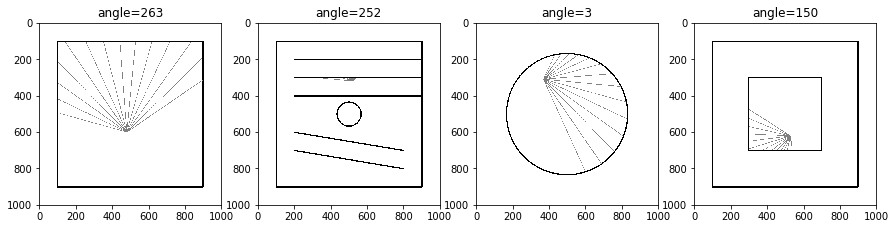

In [155]:
def raycast(pos, m, dist_max, d=0.2):
    x, y, theta = pos
    dx = math.cos(theta)
    dy = math.sin(theta)
    x_, y_ = x, y
    prev_pos = int(x_), int(y_)
    
    while True:
        x_, y_ = x_ + dx *d, y_ + dy * d
        dist = math.sqrt((x_ - x) ** 2 + (y_ - y) ** 2)
        i, j = int(y_), int(x_)
        
        if i < 0 or y < 0 or i == m.shape[0] or j == m.shape[1] or dist > dist_max:
            return None
            
        if prev_pos != (i, j) and m[i, j] == 1:
            return x_, y_
        
        prev_pos = i, j
        
def simulate_raycast():
    DIST_MAX = 1000
    STEP = 10
    FIELD = 135
    _, axes = plt.subplots(1, len(maps), figsize=(15, 10))
    for ax, m in zip(axes, maps):
        m_ = m.copy()
        x, y = random.randint(0.3 * len(m), 0.7 * len(m)), random.randint(0.3 * len(m), 0.7 * len(m))
        theta = random.uniform(0, 2 * math.pi)
        for angle in range(-FIELD // 2, FIELD // 2, STEP):
            pos = x, y, theta + math.radians(angle)
            hit = raycast(pos, m, DIST_MAX)
            if hit:
                x_, y_ = int(hit[0]), int(hit[1])
                cv.line(m_, pos[:2], (x_, y_), 0.5, 2)
            
        ax.imshow(1 - m_, cmap='gray')
        ax.set_title('angle={}'.format(int(math.degrees(theta))))
    
simulate_raycast()

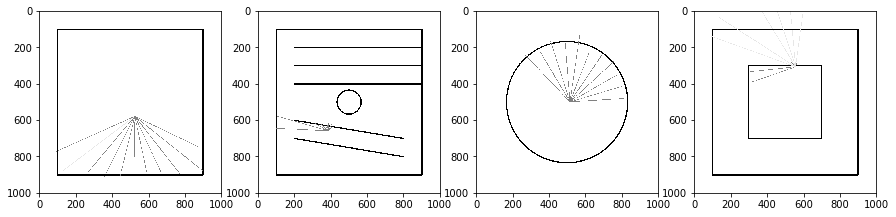

In [156]:
class Sensor:
    def __init__(self, field, n_rays, dist_max, sigma):
        self.field = field
        self.n_rays = n_rays
        self.dist_max = dist_max
        self.sigma = sigma
        self.scan_angles = [math.radians(angle) for angle in range(-self.field//2, self.field//2, self.field//self.n_rays)]
        
    def scan(self, pos, m, draw=False):
        x, y, theta = pos
        results = []
        for angle in self.scan_angles:
            dist = self._sense((x, y, theta + angle), m)
            if draw:
                x_, y_ = int(x + math.cos(theta + angle) * dist), int(y + math.sin(theta + angle) * dist)
                m = cv.line(m, (int(x), int(y)), (x_, y_), 0.1 if dist == self.dist_max else 0.5, 2)
                
            results.append(dist)
            
        return results
    
    def _sense(self, pos, m):
        hit = raycast(pos, m, self.dist_max)
        if hit is None:
            return self.dist_max
        
        x, y, _ = pos
        x_, y_ = hit
        dist = math.sqrt((x - x_) ** 2 + (y - y_) ** 2) + sample_normal_distribution(self.sigma ** 2)
        
        if dist < 0:
            return self.dist_max
        
        return dist
    
def simulate_sensor():
    DIST_MAX = 500
    N_RAYS = 10
    FIELD = 135
    SIGMA = 20
    sensor = Sensor(FIELD, N_RAYS, DIST_MAX, SIGMA)
    _, axes = plt.subplots(1, len(maps), figsize=(15, 10))
    for ax, m in zip(axes, maps):
        m_ = m.copy()
        x, y = random.randint(0.3 * len(m), 0.7 * len(m)), random.randint(0.3 * len(m), 0.7 * len(m))
        theta = random.uniform(0, 2 * math.pi)
        sensor.scan((x, y, theta), m_, draw=True)
        ax.imshow(1 - m_, cmap='gray')
        
simulate_sensor()

In [ ]:
class MonteCarloLocalization:
    def __init__(self, m, n_particles, sensor, alphas, real_pos):
        self.m = m
        self.sensor = sensor
        self.alphas = alphas
        self.real_pos = real_pos
        self.x_s = np.random.rand(n_particles) * m.shape[1]
        self.y_s = np.random.rand(n_particles) * m.shape[0]
        self.thetas = np.random.rand(n_particles) * 2 * math.pi
        
        self._filter_points()
        
    def estimated_pos(self):
        x = y = 0
        for theta in self.thetas:
            x += math.cos(theta)
            y += math.sin(theta)
            
        return np.average(self.x_s), np.average(self.y_s), math.atan2(y, x)
    
    def _filter_points(self):
        for k, (x, y, theta) in enumerate(zip(self.x_s, self.y_s, self.thetas)):
            i, j = int(y), int(x)
            while i < 0 or j < 0 or i >= self.m.shape[1] or j >= self.m.shape[0] or m[i, j]:
                x = random.random() * self.m.shape[1]
                y = random.random() * self.m.shape[0]
                theta = random.random() * 2 * math.pi
                i, j = int(y), int(x)
            self.x_s[k] = x
            self.y_s[k] = y
            self.thetas[k] = theta
    
    def predict(self, u_t):
        real_pos = sample_motion_model_odometry(u_t, self.real_pos, sample_normal_distribution, [0] * 4)
        if self.m[int(real_pos[1]), int(real_pos[0])]:
            return
        self.real_pos = real_pos
        self.x_s, self.y_s, self.thetas = sample_motion_model_odometry_n(
            u_t,
            (self.x_s,self.y_s, self.thetas),
            sample_normal_distribution,
            self.alphas
        )
        
        self._filter_points()
    
    def update(self):
        m_ = self.m.copy()
        scan = self.sensor.scan(self.real_pos, m_, draw=True)
        weights = []
        for x, y, theta in zip(self.x_s, self.y_s, self.thetas):
            p = 1
            for angle, dist in zip(self.sensor.scan_angles, scan):
                p *= measurement_model_beam(
                    (x, y, theta + angle),
                    self.m,
                    dist,
                    self.sensor.dist_max,
                    self.sensor.sigma
                )
            weights.append(p)
            
        weights = np.array(weights)
        new_particles_indexes = np.random.choice(list(range(len(weights))), len(weights), p=weights / np.sum(weights))
        self.x_s = np.array([self.x_s[i] for i in new_particles_indexes])
        self.y_s = np.array([self.y_s[i] for i in new_particles_indexes])
        self.thetas = np.array([self.thetas[i] for i in new_particles_indexes])
        
        return m_

def simulate_monte_carlo_localization():
    mcl = MonteCarloLocalization(
        maps[1],
        100,
        Sensor(150, 12, 0.3 * MAP_SIZE, 1),
        [0.1] * 4,
        (0.4 * MAP_SIZE, 0.6 * MAP_SIZE, math.radians(-90))
    )
    D = 1
    T = 5
    commands = [
        [-T, D, 0],
        [-T, D, 0],
        [-T, D, 0],
        [-T, D, 0],
        [-T, D, 0],
        [-T, D, 0],
        [-T, D, 0],
        [-T, D, 0],
    ]
    
    fig, axes = plt.subplots(len(commands), 2, figsize=(10, 5 * len(commands)))
    for ax, cmd in zip(axes, commands):
        ax[0].imshow(1 - mcl.m, cmap='gray')
        ax[0].plot(mcl.x_s, mcl.y_s, 'k.', alpha=0.2)
        mcl.predict((math.radians(cmd[0]), cmd[1], math.radians(cmd[2])))
        ax[0].plot(mcl.real_pos[0], mcl.real_pos[1], 'r.', marker=(3, 0, -math.degrees(mcl.real_pos[2]) - 90), markersize=10)
        ax[0].plot(mcl.x_s, mcl.y_s, 'k.', alpha=0.5)
        
        m_ = mcl.update()
        estimated_pos = mcl.estimated_pos()
        ax[1].imshow(1 - m_, cmap='gray')
        ax[1].plot(mcl.real_pos[0], mcl.real_pos[1], 'r.', marker=(3, 0, -math.degrees(mcl.real_pos[2]) - 90), markersize=10)
        ax[1].plot(estimated_pos[0], estimated_pos[1], 'c.', marker=(3, 0, -math.degrees(estimated_pos[2]) - 90), markersize=10)
        ax[1].plot(mcl.x_s, mcl.y_s, 'k.', alpha=0.5)
        
        ax[0].set_ylim((MAP_SIZE, 0))
        ax[0].set_xlim((0, MAP_SIZE))
        
        ax[1].set_ylim((MAP_SIZE, 0))
        ax[1].set_xlim((0, MAP_SIZE))
    
simulate_monte_carlo_localization()